In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
################
#### Paths #####
################
# Update these for reproduction
project_data_path = "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/"

# Location plots

### Setup

In [33]:
def plot_location(city, metric, var_id, years, ssp):
    
    metric_varid = f"{metric}_{var_id}"
    
    # Read all
    df_loca = pd.read_csv(f'{project_data_path}/summary_raw/{city}_LOCA2_{ssp}_{years}_{metric_varid}.csv')
    df_nex = pd.read_csv(f'{project_data_path}/summary_raw/{city}_NEX-GDDP-CMIP6_{ssp}_{years}.csv')
    df_cil = pd.read_csv(f'{project_data_path}/summary_raw/{city}_CIL-GDPCIR_{ssp}_{years}.csv')

    ## Plot
    fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[3, 1], gridspec_kw={'hspace':0.0})

    # PDFs
    ax=axs[0]
    
    df_loca[metric_varid].plot.kde(ax=ax, lw=2, label='LOCA')
    df_nex[metric_varid].plot.kde(ax=ax, lw=2, label='NEX')
    df_cil[metric_varid].plot.kde(ax=ax, lw=2, label='CIL')

    ax.set_yticklabels([])
    ax.legend()
    ax.grid()

    # Boxplots
    ax=axs[1]

    for idx, data in enumerate([df_loca[metric_varid].dropna(),
                                df_nex[metric_varid].dropna(),
                                df_cil[metric_varid].dropna()]):
        # ax.scatter(x=[np.nanquantile(data, 0.99)], y=[idx+1],
        #            color=f'C{idx}', marker='x', s=50)
        
        bp = ax.boxplot(x=data, positions=[idx+1], patch_artist=True,
                        capprops = dict(color=f'C{idx}', linewidth=1.5),
                        boxprops = dict(color=f'C{idx}', linewidth=1.5),
                        whiskerprops = dict(color=f'C{idx}', linewidth=1.5),
                        medianprops = dict(color='white', linewidth=1),
                        vert=False, showmeans=False, whis=(0.5, 99.5), showfliers=False, widths=0.4)

        for patch in bp['boxes']:
            patch.set_facecolor(f'C{idx}')
        
        # ax.errorbar(x=np.mean(data), y=idx+1,
        #             xerr=2*np.std(data),
        #             color=f'C{idx}', marker='o', markersize=8)
    
    if var_id == 'pr':
        ax.set_xlim([0., 1.01*np.max([df_loca[metric_varid].max(), df_nex[metric_varid].max(), df_cil[metric_varid].max()])])
    else:
        ax.set_xlim([0.95*np.min([df_loca[metric_varid].min(), df_nex[metric_varid].min(), df_cil[metric_varid].min()]),
                     1.05*np.max([df_loca[metric_varid].max(), df_nex[metric_varid].max(), df_cil[metric_varid].max()])])
        
    ax.set_ylim([0.5, 3.5])
    ax.set_yticks([])
    ax.grid()

    # Construct suptitle
    title_str = {'avg_tas': 'Annual Average Daily Temperature',
                 'max_tasmax': 'Annual Maximum Daily Maximum Temperature',
                 'sum_pr': 'Annual Total Precipitation',
                 'max_pr': 'Annual Maximum 1-Day Precipitation'}
    line1 = f"{city.capitalize()} {title_str[metric_varid]}"
    line2 = f"{years} under {ssp[:4].upper()}-{ssp[4]}.{ssp[5]}"
    fig.suptitle(f"{line1}\n{line2}", weight='bold')
    
    plt.show()

### Plots

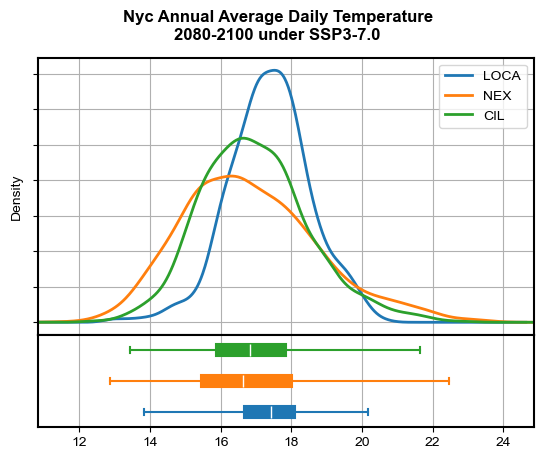

In [37]:
plot_location(city = "nyc",
              metric = "avg",
              var_id = "tas",
              years = "2080-2100",
              ssp = 'ssp370')

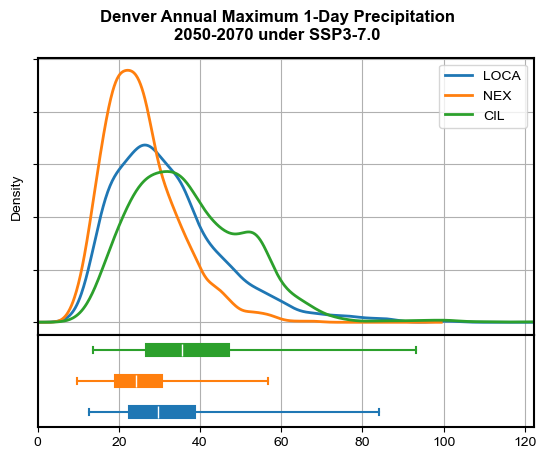

In [34]:
plot_location(city = "denver",
              metric = "max",
              var_id = "pr",
              years = "2050-2070",
              ssp = 'ssp370')

# Map plots

### Setup

In [3]:
# def main_comparison_plot(ssp, years, var_id, metric, indice,
#                          suptitle, 
#                          vmin_ind, vmax_ind, vdiff,
#                          ind_levels, diff_levels,
#                          cmap_ind, cmap_diff='RdBu_r'):
#     #####################
#     # Read all ensembles
#     #####################
#     # NEX-GDDP-CMIP6
#     ds_nex = xr.open_dataset(f"{project_data_path}/NEX-GDDP-CMIP6_{ssp}_{years}.nc").assign_coords(ensemble='NEX-GDDP')

#     # CIL-GDPCIR
#     ds_cil = xr.open_dataset(f"{project_data_path}/CIL-GDPCIR_{ssp}_{years}.nc").assign_coords(ensemble='CIL-GDPCIR')
#     ds_cil = ds_cil.rename({'pr_max':'max_pr', 'tas_avg':'avg_tas', 'pr_sum':'sum_pr', 'tasmax_max':'max_tasmax'})

#     # LOCA2
#     metrics = ['avg_tas', 'sum_pr', 'max_tasmax', 'max_pr']
#     ds_loca = xr.merge([xr.open_dataset(f"{project_data_path}/LOCA2_{ssp}_{years}_{metric}.nc") for metric in metrics])
#     ds_loca = ds_loca.assign_coords(ensemble='LOCA2')

#     # Merge all
#     ds = xr.concat([ds_nex, ds_loca, ds_cil], dim='ensemble')

#     ###########################
#     # Useful plotting funcs
#     ###########################
#     def tidy_ax(ax, p, title):
#             # Tidy
#             ax.coastlines()
#             ax.set_title(title)
#             ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
#             ax.set_extent([-120, -73, 21, 55], ccrs.Geodetic())
#             # Colorbar
#             fig.colorbar(p,
#                          orientation="horizontal",
#                          shrink = 0.9,
#                          ax=ax,
#                          pad=0.04)

#     #############
#     # Main plot
#     #############
#     ensembles = ['LOCA2', 'NEX-GDDP', 'CIL-GDPCIR']

#     fig, axs = plt.subplots(3, 3, figsize=(12, 10),
#                         gridspec_kw=dict(wspace=0.01, hspace=0.2),
#                         subplot_kw=dict(projection=ccrs.LambertConformal()))

#     # Iterate through all combinations
#     for i1, ens1 in enumerate(ensembles):
#         for i2, ens2 in enumerate(ensembles):
#             # Set axis
#             ax = axs[i1, i2]
#             # DIAGONAL
#             if i1 == i2:
#                 # Individual plot
#                 ds_plot = ds.sel(indice=indice, ensemble=ens1)[f"{metric}_{var_id}"]
#                 p = ds_plot.plot(ax=ax,
#                                  vmin=vmin_ind, vmax=vmax_ind,
#                                  cmap=cmap_ind, add_colorbar=False, levels=ind_levels,
#                                  transform=ccrs.PlateCarree())
#                 # Tidy
#                 tidy_ax(ax, p, ens1)
#             # OFF DIAGONAL MAP
#             elif i1 > i2:
#                 # Difference plot
#                 ds_diff = ds.sel(indice=indice, ensemble=ens1)[f"{metric}_{var_id}"] - ds.sel(indice=indice, ensemble=ens2)[f"{metric}_{var_id}"]
#                 p = ds_diff.plot(ax=ax,
#                                  vmin=-vdiff, vmax=vdiff,
#                                  cmap=cmap_diff, add_colorbar=False, levels=diff_levels,
#                                  transform=ccrs.PlateCarree())
#                 # Tidy
#                 tidy_ax(ax, p, f"{ens1} minus {ens2}")
#             # OFF DIAGONAL DIST
#             else:
#                 ax.axis('off')
#     # Add suptitle
#     fig.suptitle(suptitle, y=0.92, weight='bold')

In [21]:
def main_comparison_plot(ssp, years, var_id, metric, indice,
                         vdiff, cmap_ind,
                         ind_levels = 11,
                         diff_levels = 11,
                         cmap_diff='RdBu_r'):
    #####################
    # Read all ensembles
    #####################
    metric_varid = f"{metric}_{var_id}"
    
    # NEX-GDDP-CMIP6
    ds_nex = xr.open_dataset(f"{project_data_path}/summary_indices/NEX-GDDP-CMIP6_{ssp}_{years}.nc")
    ds_nex = ds_nex[[metric_varid]].assign_coords(ensemble='NEX-GDDP')

    # CIL-GDPCIR
    ds_cil = xr.open_dataset(f"{project_data_path}/summary_indices/CIL-GDPCIR_{ssp}_{years}.nc")
    ds_cil = ds_cil.rename({'pr_max':'max_pr', 'tas_avg':'avg_tas', 'pr_sum':'sum_pr', 'tasmax_max':'max_tasmax'})
    ds_cil = ds_cil[[metric_varid]].assign_coords(ensemble='CIL-GDPCIR')

    # LOCA2
    metrics = ['avg_tas', 'sum_pr', 'max_tasmax', 'max_pr']
    # ds_loca = xr.merge([xr.open_dataset(f"{project_data_path}/summary_indices/LOCA2_{ssp}_{years}_{metric}.nc") for metric in metrics])
    ds_loca = xr.open_dataset(f"{project_data_path}/summary_indices/LOCA2_{ssp}_{years}_{metric_varid}.nc")
    ds_loca = ds_loca.assign_coords(ensemble='LOCA2')

    # Merge all
    ds = xr.concat([ds_nex, ds_loca, ds_cil], dim='ensemble')

    ###########################
    # Useful plotting funcs
    ###########################
    def tidy_ax(ax, p, title):
            # Tidy
            ax.coastlines()
            ax.set_title(title)
            ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
            ax.set_extent([-120, -73, 21, 55], ccrs.Geodetic())

    #############
    # Main plot
    #############
    ensembles = ['LOCA2', 'NEX-GDDP', 'CIL-GDPCIR']

    fig, axs = plt.subplots(2, 3, figsize=(12, 6),
                            gridspec_kw=dict(wspace=0.03, hspace=0.05),
                            subplot_kw=dict(projection=ccrs.LambertConformal()))

    # Set limits based on variable
    vmin_ind = {'pr': 0.,
                'tas': 10 * round(ds.sel(indice=indice)[metric_varid].quantile(0.01).values/10),
                'tasmax': 10 * round(ds.sel(indice=indice)[metric_varid].quantile(0.01).values/10)}

    vmax_ind = {'pr': 50 * round(ds.sel(indice=indice)[metric_varid].quantile(0.99).values/50),
                'tas': 10 * round(ds.sel(indice=indice)[metric_varid].quantile(0.99).values/10),
                'tasmax': 10 * round(ds.sel(indice=indice)[metric_varid].quantile(0.99).values/10)}
    
    # Iterate through all individual
    for ixe, ensemble in enumerate(ensembles):
        # Set axis
        ax = axs[0, ixe]
        # Individual plot
        ds_plot = ds.sel(indice=indice, ensemble=ensemble)[metric_varid]
        p = ds_plot.plot(ax=ax,
                         vmin=vmin_ind[var_id], vmax=vmax_ind[var_id],
                         cmap=cmap_ind, add_colorbar=False, levels=ind_levels,
                         transform=ccrs.PlateCarree())
        # Tidy
        tidy_ax(ax, p, ensemble)
    # Colorbar for first row
    cbar = fig.colorbar(p,
                 orientation="vertical",
                 shrink=0.8,
                 extend='neither',
                 aspect=15,
                 ax=axs[0,:],
                 pad=0.01)
    units_str = {'pr': '[mm]', 'tas':'[C]', 'tasmax':'[C]'}
    indice_str = {'mean': 'Ensemble Mean',
                  'q99': 'Ensemble 99th Percentile',
                  '99range': 'Ensemble 99% Range'}

    cbar.ax.set_ylabel(f'{indice_str[indice]} {units_str[var_id]}', rotation=-90, va="bottom")
    
    # Iterate through all combination
    combos = [('LOCA2', 'NEX-GDDP'), ('LOCA2', 'CIL-GDPCIR'), ('NEX-GDDP', 'CIL-GDPCIR')]
    for ixe, ensemble in enumerate(combos):
        ax = axs[1, ixe]
        ens1, ens2 = ensemble
        # Difference plot
        ds_diff = ds.sel(indice=indice, ensemble=ens1)[metric_varid] - ds.sel(indice=indice, ensemble=ens2)[metric_varid]
        p = ds_diff.plot(ax=ax,
                         vmin=-vdiff, vmax=vdiff,
                         cmap=cmap_diff, add_colorbar=False, levels=diff_levels,
                         transform=ccrs.PlateCarree())
        # Tidy
        tidy_ax(ax, p, f"{ens1} minus {ens2}")
        
    # Colorbar for second row
    cbar = fig.colorbar(p,
                 orientation="vertical",
                 shrink=0.8,
                 extend='neither',
                 aspect=15,
                 ax=axs[1,:],
                 pad=0.01)
    cbar.ax.set_ylabel(f'Difference {units_str[var_id]}', rotation=-90, va="bottom")
    
    # Construct suptitle
    title_str = {'avg_tas': 'Annual Average Daily Temperature',
                 'max_tasmax': 'Annual Maximum Daily Maximum Temperature',
                 'sum_pr': 'Annual Total Precipitation',
                 'max_pr': 'Annual Maximum 1-Day Precipitation'}
    line1 = title_str[metric_varid]
    
    ssp_str = f"{ssp[:4].upper()}-{ssp[4]}.{ssp[5]}"
    line2 = f"{ssp_str} {indice_str[indice]} over {years}"
    
    fig.suptitle(f"{line1}\n{line2}", x=0.45, y=0.96, weight='bold')

### Plots

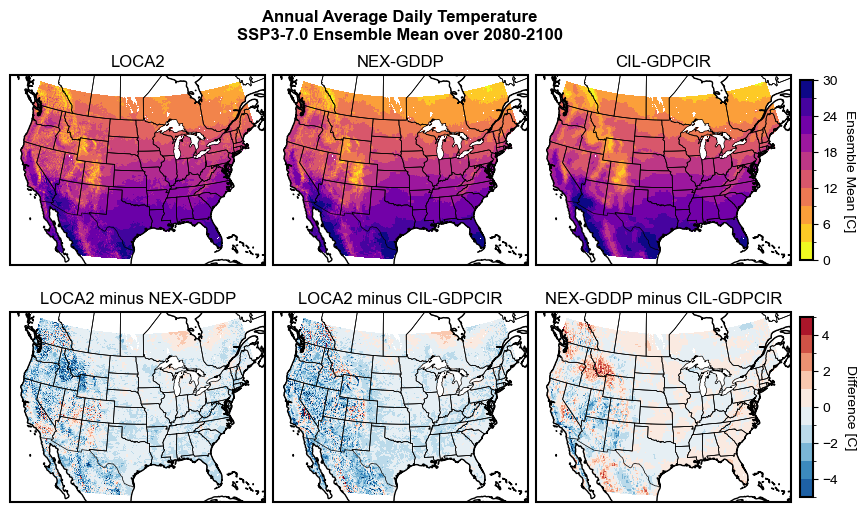

In [31]:
main_comparison_plot(ssp = 'ssp370',
                     years = '2080-2100',
                     var_id = 'tas',
                     metric = 'avg',
                     indice = 'mean',
                     vdiff = 5.,
                     cmap_ind = 'plasma_r')

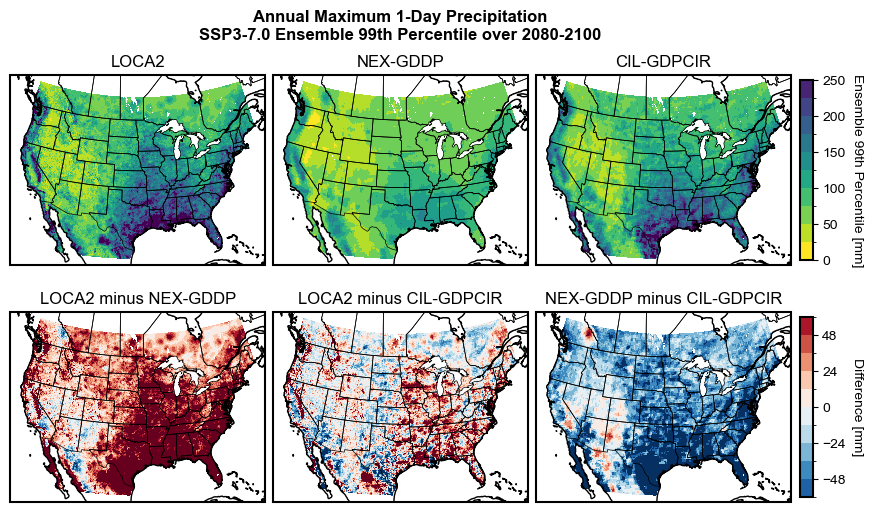

In [24]:
main_comparison_plot(ssp = 'ssp370',
                     years = '2080-2100',
                     var_id = 'pr',
                     metric = 'max',
                     indice = 'q99',
                     vdiff = 60.,
                     cmap_ind = 'viridis_r')